In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

---  
Original version

In [20]:
from tensorflow.examples.tutorials.mnist import input_data

In [21]:
batch_size = 128
test_size = 256

def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.01))
      
def model(X, w, w2, w3, w4, w_o, p_keep_conv, p_keep_hidden):
    
    l1a = tf.nn.relu(tf.nn.conv2d(X, w,                       # l1a shape=(?, 28, 28, 32)
                        strides=[1, 1, 1, 1], padding='SAME'))
    l1 = tf.nn.max_pool(l1a, ksize=[1, 2, 2, 1],              # l1 shape=(?, 14, 14, 32)
                        strides=[1, 2, 2, 1], padding='SAME')
    l1 = tf.nn.dropout(l1, p_keep_conv)

    l2a = tf.nn.relu(tf.nn.conv2d(l1, w2,                     # l2a shape=(?, 14, 14, 64)
                        strides=[1, 1, 1, 1], padding='SAME'))
    l2 = tf.nn.max_pool(l2a, ksize=[1, 2, 2, 1],              # l2 shape=(?, 7, 7, 64)
                        strides=[1, 2, 2, 1], padding='SAME')
    l2 = tf.nn.dropout(l2, p_keep_conv)

    l3a = tf.nn.relu(tf.nn.conv2d(l2, w3,                     # l3a shape=(?, 7, 7, 128)
                        strides=[1, 1, 1, 1], padding='SAME'))
    l3 = tf.nn.max_pool(l3a, ksize=[1, 2, 2, 1],              # l3 shape=(?, 4, 4, 128)
                        strides=[1, 2, 2, 1], padding='SAME')
    l3 = tf.reshape(l3, [-1, w4.get_shape().as_list()[0]])    # reshape to (?, 2048)
    l3 = tf.nn.dropout(l3, p_keep_conv)

    l4 = tf.nn.relu(tf.matmul(l3, w4))
    l4 = tf.nn.dropout(l4, p_keep_hidden)

    pyx = tf.matmul(l4, w_o)
    return pyx

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels
trX = trX.reshape(-1, 28, 28, 1)  # 28x28x1 input img
teX = teX.reshape(-1, 28, 28, 1)  # 28x28x1 input img

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [22]:
X = tf.placeholder("float", [None, 28, 28, 1])
Y = tf.placeholder("float", [None, 10])

w = init_weights([3, 3, 1, 32])       # 3x3x1 conv, 32 outputs
w2 = init_weights([3, 3, 32, 64])     # 3x3x32 conv, 64 outputs
w3 = init_weights([3, 3, 64, 128])    # 3x3x32 conv, 128 outputs
w4 = init_weights([128 * 4 * 4, 784]) # FC 128 * 4 * 4 inputs, 625 outputs
w_o = init_weights([784, 10])         # FC 625 inputs, 10 outputs (labels)

p_keep_conv = tf.placeholder("float")
p_keep_hidden = tf.placeholder("float")
py_x = model(X, w, w2, w3, w4, w_o, p_keep_conv, p_keep_hidden)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=py_x, labels=Y))
train_op = tf.train.RMSPropOptimizer(0.001, 0.9).minimize(cost)
predict_op = tf.argmax(py_x, 1)

In [23]:
# Launch the graph in a session
with tf.Session() as sess:
    # you need to initialize all variables
    tf.global_variables_initializer().run()

    for i in range(5):
        training_batch = zip(range(0, len(trX), batch_size),
                             range(batch_size, len(trX)+1, batch_size))
        for start, end in training_batch:
            sess.run(train_op, feed_dict={X: trX[start:end], Y: trY[start:end],
                                          p_keep_conv: 0.8, p_keep_hidden: 0.5})

        test_indices = np.arange(len(teX)) # Get A Test Batch
        np.random.shuffle(test_indices)
        test_indices = test_indices[0:test_size]

        print(i, np.mean(np.argmax(teY[test_indices], axis=1) ==
                         sess.run(predict_op, feed_dict={X: teX[test_indices],
                                                         Y: teY[test_indices],
                                                         p_keep_conv: 1.0,
                                                         p_keep_hidden: 1.0})))

0 0.9609375
1 0.9765625
2 0.97265625
3 0.9921875
4 0.9921875


---  
Reworked version

In [32]:
tf.reset_default_graph()

In [33]:
X = tf.placeholder("float", [None, 28, 28, 1])
Y = tf.placeholder("float", [None, 10])

In [34]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [35]:
trX = tf.reshape(x_train, [-1, 28, 28, 1])
trY = tf.one_hot(y_train, 10)
teX = tf.reshape(x_test, [-1, 28, 28, 1])
teY = tf.one_hot(y_test, 10)

In [36]:
def init_weight(shape):
    return tf.Variable(tf.random_normal(shape, stddev= 0.01))

In [37]:
def model(X, dimensions, filters, dropout, strides, padding='SAME'):
    
    input_dim = 1
    
    current_layer = X
    
    for i, dim_i in enumerate(dimensions):
        with tf.variable_scope("layer/{}".format(i)):
            if i < len(dimensions)-1:
                W = init_weight([filters[i], 
                                 filters[i], 
                                 input_dim, 
                                 dim_i])

                h = tf.nn.relu(
                    tf.nn.conv2d(current_layer,
                                 W, 
                                 strides[0], 
                                 padding))
                
                h = tf.nn.max_pool(h,
                                  strides[1],
                                  strides[1],
                                  padding)
                
                h = tf.nn.dropout(h, dropout[0])
                
                current_layer = h
                input_dim = dim_i
                
            else:
                
                h = tf.contrib.layers.flatten(h)
                h = tf.nn.dropout(h, dropout[1])
                
                W = init_weight([h.get_shape().as_list()[1], 784])

                h = tf.nn.relu(tf.matmul(h, W))
                h = tf.nn.dropout(h, dropout[1])
    
    W_out = init_weight([784, 10])
    return tf.matmul(h, W_out)

In [38]:
dimensions = [32, 64, 128]
filters = [3, 3, 3]

dropout = tf.placeholder("float", shape=(2))
strides = [[1,1,1,1], [1,2,2,1]]

py_x = model(X, dimensions, filters, dropout, strides)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=py_x, labels=Y))
train_op = tf.train.AdamOptimizer(0.001).minimize(cost)
predict_op = tf.argmax(py_x, 1)

In [39]:
batch_size = 128
test_size = 256

Iteration: 0 | Cost: 0.13092855 | Accuracy: 0.94140625
Iteration: 1 | Cost: 0.0767821 | Accuracy: 0.9765625
Iteration: 2 | Cost: 0.065050244 | Accuracy: 0.96875
Iteration: 3 | Cost: 0.045805786 | Accuracy: 0.98828125
Iteration: 4 | Cost: 0.028879274 | Accuracy: 0.9921875


Text(0,1,'Accuracy')

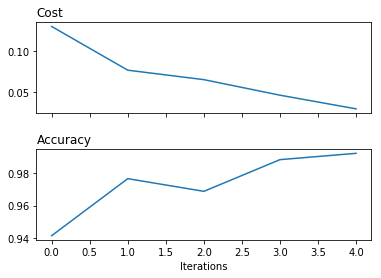

In [40]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()

    trX = trX.eval()
    trY = trY.eval()
    teX = teX.eval()
    teY = teY.eval()

    cost_evolution = []
    accuracy_evolution = []
    
    for i in range(5):
        
        training_batch = zip(range(0, len(trX), batch_size),
                            range(batch_size, len(trX)+1, batch_size))
        
        for start, end in training_batch:
            sess.run(train_op, feed_dict={X: trX[start:end],
                                         Y: trY[start:end],
                                         dropout: [0.8, 0.5]})
        test_indices = np.arange(len(teX))
        np.random.shuffle(test_indices)
        test_indices = test_indices[0:test_size]
        
        cost_i = sess.run(cost, feed_dict={X: teX[test_indices],
                                                 Y: teY[test_indices],
                                                 dropout: [1.0, 1.0]})
        cost_evolution.append((i, cost_i))
        
        acc_i = np.mean(np.argmax(teY[test_indices], axis=1) ==
                             sess.run(predict_op, feed_dict={X: teX[test_indices],
                                                            Y: teY[test_indices],
                                                            dropout: [1.0, 1.0]}))
        accuracy_evolution.append((i, acc_i))

        
        print('Iteration:', i,
             '| Cost:', sess.run(cost, feed_dict={X: teX[test_indices],
                                                 Y: teY[test_indices],
                                                 dropout: [1.0, 1.0]}),
             '| Accuracy:', np.mean(np.argmax(teY[test_indices], axis=1) ==
                             sess.run(predict_op, feed_dict={X: teX[test_indices],
                                                            Y: teY[test_indices],
                                                            dropout: [1.0, 1.0]})))


fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
plt.subplots_adjust(hspace=0.4)
ax1.plot(*zip(*cost_evolution))
ax1.set_title('Cost', loc='left')
ax2.set_xlabel('Iterations')
ax2.plot(*zip(*accuracy_evolution))
ax2.set_title('Accuracy', loc='left')